# Detectron2 

# Install detectron2

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44089 sha256=956668d1fa6b31006a4740fec087a193cfaf05abc906f549fba0ec0fe61d95a1
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.6.7 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/CNN/Detectron2_card

/content/drive/MyDrive/CNN/Detectron2_card


In [ ]:
!unzip data_detectron2.zip

Archive:  data_detectron2.zip
  inflating: data_detectron2/output.json  
   creating: data_detectron2/train/
  inflating: data_detectron2/train/cam_image1.jpg  
  inflating: data_detectron2/train/cam_image10.jpg  
  inflating: data_detectron2/train/cam_image11.jpg  
  inflating: data_detectron2/train/cam_image12.jpg  
  inflating: data_detectron2/train/cam_image13.jpg  
  inflating: data_detectron2/train/cam_image14.jpg  
  inflating: data_detectron2/train/cam_image15.jpg  
  inflating: data_detectron2/train/cam_image16.jpg  
  inflating: data_detectron2/train/cam_image17.jpg  
  inflating: data_detectron2/train/cam_image18.jpg  
  inflating: data_detectron2/train/cam_image19.jpg  
  inflating: data_detectron2/train/cam_image20.jpg  
  inflating: data_detectron2/train/cam_image21.jpg  
  inflating: data_detectron2/train/cam_image22.jpg  
  inflating: data_detectron2/train/cam_image23.jpg  
  inflating: data_detectron2/train/cam_image24.jpg  
  inflating: data_detectron2/train/cam_image

In [ ]:
%cd data_detectron2

/content/drive/MyDrive/CNN/Detectron2_card/data_detectron2


# Register data

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("customtrain1", {}, "./output.json", "./train")

In [ ]:
sample_metadata = MetadataCatalog.get("customtrain1")
dataset_dicts = DatasetCatalog.get("customtrain1")

WARNING [03/30 05:54:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/30 05:54:22 d2.data.datasets.coco]: Loaded 290 images in COCO format from ./output.json


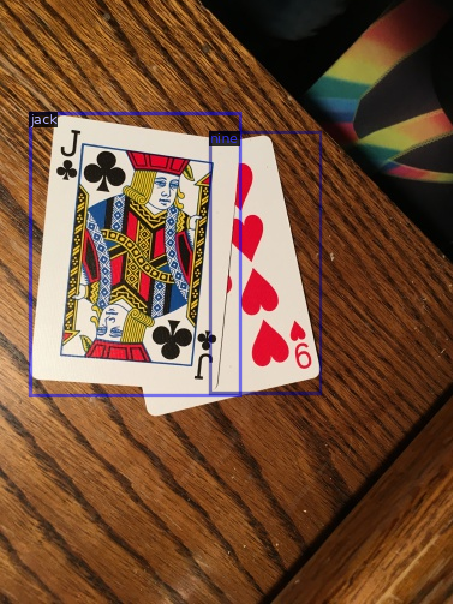

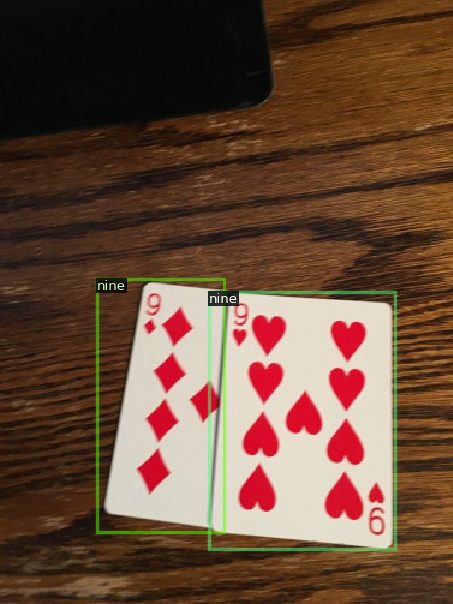

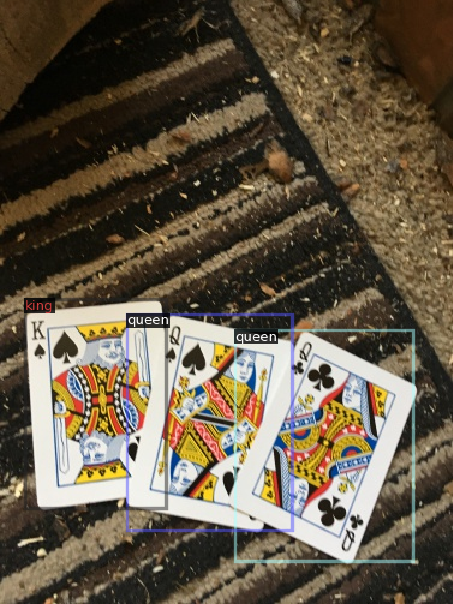

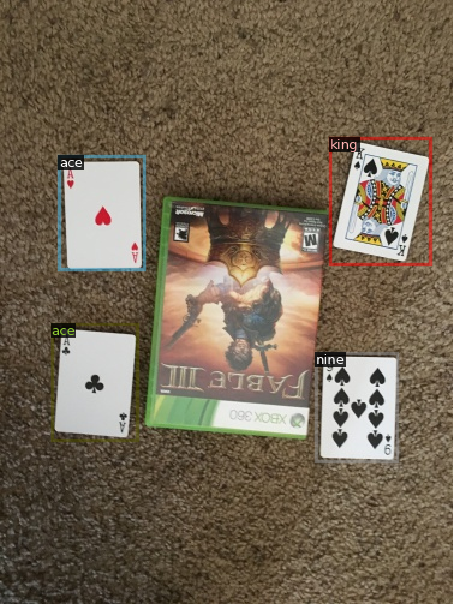

In [ ]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=1.2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Training

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("customtrain1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 50    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[03/26 10:34:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 114MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/26 10:34:18 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/26 10:34:35 d2.utils.events]:  eta: 0:00:11  iter: 19  total_loss: 1.89  loss_cls: 1.004  loss_box_reg: 0.7415  loss_rpn_cls: 0.003817  loss_rpn_loc: 0.003949    time: 0.3905  last_time: 0.4489  data_time: 0.0202  last_data_time: 0.0358   lr: 0.00095155  max_mem: 2641M
[03/26 10:34:42 d2.utils.events]:  eta: 0:00:03  iter: 39  total_loss: 1.347  loss_cls: 0.5477  loss_box_reg: 0.7984  loss_rpn_cls: 0.001447  loss_rpn_loc: 0.003338    time: 0.3833  last_time: 0.3779  data_time: 0.0090  last_data_time: 0.0142   lr: 0.0019506  max_mem: 2641M
[03/26 10:34:48 d2.utils.events]:  eta: 0:00:00  iter: 49  total_loss: 1.167  loss_cls: 0.4916  loss_box_reg: 0.6629  loss_rpn_cls: 0.0007082  loss_rpn_loc: 0.004865    time: 0.3837  last_time: 0.3802  data_time: 0.0083  last_data_time: 0.0069   lr: 0.0024501  max_mem: 2641M
[03/26 10:34:48 d2.engine.hooks]: Overall training speed: 48 iterations in 0:00:18 (0.3837 s / it)
[03/26 10:34:48 d2.engine.hooks]: Total training time: 0:00:19 (0:00:01 on h

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("customtrain1", )
predictor = DefaultPredictor(cfg)

[03/26 10:36:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


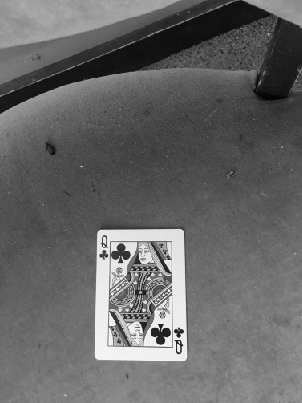

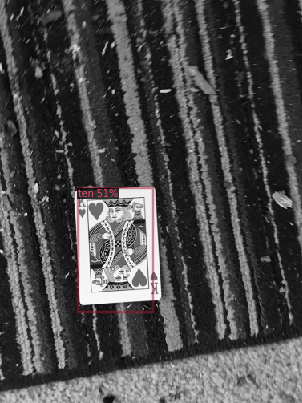

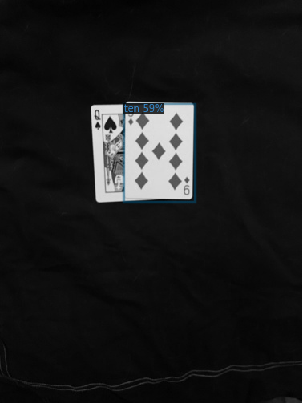

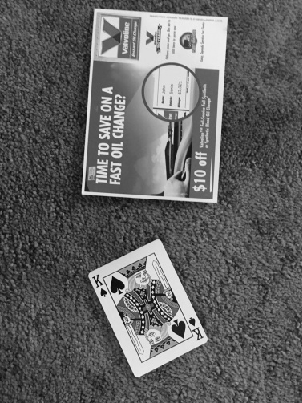

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
%cd data_detectron2

[Errno 2] No such file or directory: 'data_detectron2'
/content/drive/MyDrive/Classes/Detectron2_detection/data_detectron2


# Evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("customtrain1", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "customtrain1")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [03/26 10:38:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/26 10:38:54 d2.data.datasets.coco]: Loaded 290 images in COCO format from ./output.json
[03/26 10:38:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/26 10:38:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/26 10:38:54 d2.data.common]: Serializing 290 elements to byte tensors and concatenating them all ...
[03/26 10:38:54 d2.data.common]: Serialized dataset takes 0.07 MiB
[03/26 10:38:54 d2.evaluation.evaluator]: Start inference on 290 batches
[03/26 10:38:56 d2.evaluation.evaluator]: Inference done 11/290. Dataloading: 0.0016 s/iter. Inference: 0.0985 s/iter. Eval: 0.0003 s/iter. Total: 0.1004 s/iter. ETA=0:00:28
[03/26 10:39:01 d2.evaluation.evaluator]: Inference do

### Getting the custom config file

In [ ]:
pwd

'/content/drive/MyDrive/Classes/Detectron2_detection/data_detectron2'

In [ ]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()